In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dependencies
!pip install biopython
!apt-get install -y mafft
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-lato libauthen-sasl-perl libclone-perl libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl
  libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libio-html-perl libio-socket-ssl-perl
  liblwp-mediatypes-perl liblwp-protocol-https-perl libmailtools-perl
  libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl libruby3.0
  libtry-tiny-perl liburi-perl libwww-perl libwww-robotrules-perl lynx
  lynx-common netbase perl-openssl-defaults rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration
Suggested packages:
  libdigest-hmac-perl libgssap

Textarea(value='', description='Query Seq:', layout=Layout(height='100px', width='100%'), placeholder='Paste y…

Button(button_style='success', description='Enter', style=ButtonStyle())

Button(button_style='info', description='Run Example Input', style=ButtonStyle())

Output()

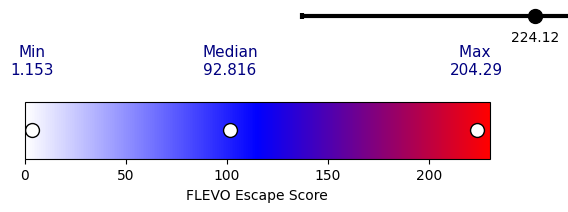

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from Bio.Seq import Seq
from Bio import SeqIO, AlignIO
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
from io import StringIO
import Levenshtein

# Load FLEVO escape scores
evescape_df = pd.read_csv("prrsv_scaled_flevo_scores.csv")
evescape_df["mutations"] = evescape_df["wt"] + evescape_df["i"].astype(str) + evescape_df["mut"]
evescape_dict_pos = dict(zip(evescape_df["mutations"], evescape_df["evescape"] - evescape_df["evescape"].min()))
evescape_dict_sigmoid = dict(zip(evescape_df["mutations"], evescape_df["evescape"].apply(lambda x: 1 / (1 + math.exp(-x)))))

# Reference sequence
ref_aa_seq = "MLEKCLTAGYCSQLLFFWCIVPFCFAALVNAASNSSSHLQLIYNLTICELNGTDWLNQKFDWAVETFVIFPVLTHIVSYGALTTSHFLDTAGLITVSTAGYYHGRYVLSSIYAVFALAALICFVIRLTKNCMSWRYSCTRYTNFLLDTKGNLYRWRSPVVIERRGKVEVGDHLIDLKRVVLDGSAATPITKISAEQWGRP"

# Mutation extraction using MAFFT
def get_mutations(wt_seq, query_seq):
    with open("temp.fasta", "w") as f:
        f.write(">WT\n" + wt_seq + "\n")
        f.write(">QUERY\n" + query_seq + "\n")

    result = subprocess.run(
        ["mafft", "--globalpair", "--maxiterate", "1000", "--quiet", "temp.fasta"],
        capture_output=True, text=True, check=True
    )

    alignment = AlignIO.read(StringIO(result.stdout), "fasta")
    wt_aligned = str(alignment[0].seq)
    query_aligned = str(alignment[1].seq)

    mutations = []
    wt_pos = 0
    for wt_res, q_res in zip(wt_aligned, query_aligned):
        if wt_res != "-":
            wt_pos += 1
        if wt_res == "-" and q_res != "-":
            mutations.append(f"{wt_aligned[wt_pos-1]}{wt_pos}ins{q_res}")
        elif wt_res != "-" and q_res == "-":
            mutations.append(f"{wt_res}{wt_pos}del")
        elif wt_res != "-" and q_res != "-" and wt_res != q_res:
            mutations.append(f"{wt_res}{wt_pos}{q_res}")
    return mutations

# Widgets
query_input = widgets.Textarea(
    value='',
    placeholder='Paste your ORF5 GP5 amino acid sequence (200 aa)',
    description='Query Seq:',
    layout=widgets.Layout(width='100%', height='100px')
)

enter_button = widgets.Button(description="Enter", button_style='success')
example_button = widgets.Button(description="Run Example Input", button_style='info')
output_area = widgets.Output()

# Example sequence
example_sequence = "MLGKCLTAGCCSQLPFLWCIVPFCFVALVNASNNSSSHLQLIYNLTICELNGTDWLNKSFDWAVETFVIFPVLTHIVSYGALTTSHFLDTVGLITVSAAGYYHGRYVLSSIYAVCALAALTCFVIRLTKNCMSWRYSCTRYTNFLQDTKGKLYRWRSPVIIEKGGKIEVEGHLIDLKRVVLDGSAATPVTKVSAEQWGRP"

def on_enter_clicked(b):
    output_area.clear_output(wait=True)
    with output_area:
        raw_input = query_input.value
        query_seq_input = ''.join(raw_input.split()).replace('-', '').upper()

        query_seq = Seq(query_seq_input)

        # Levenshtein distance
        lev_dist = Levenshtein.distance(ref_aa_seq, str(query_seq))
        similarity = (1 - lev_dist / 200) * 100
        print(f"Levenshtein distance from WT: {lev_dist}")
        print(f"Similarity to WT: {similarity:.2f}%")

        # Mutation list from MAFFT
        mutations = get_mutations(ref_aa_seq, str(query_seq))
        filtered_mutations = [m for m in mutations if 'del' not in m and 'ins' not in m]

        score_pos = sum(evescape_dict_pos.get(m, 0) for m in filtered_mutations)
        score_sigmoid = sum(evescape_dict_sigmoid.get(m, 0) for m in filtered_mutations)
        print(f"EscaPRRS score: {score_pos:.3f}")


        if similarity < 30:
           uncertainty = 100
           print("This sequence is not likely that of PRRSV-2 GP5")
        else:
           uncertainty=(lev_dist / 200) * 100
        print(f"Uncertainty: {uncertainty:.3f}%")

        minimum = 1.1572728000000003
        maximum = 204.29259040000005
        mean = 92.8164662
        diff_sig_min = abs(score_pos - minimum)
        diff_sig_mean = abs(score_pos - mean)
        diff_sig_max = abs(maximum - score_pos)

        position_mean = (
            "above median" if score_pos > mean else
            "equal to median" if score_pos == mean else
            "below median"
        )
        print(f"- Relative score from minimum escape mutant: {diff_sig_min:.3f}")
        print(f"- Relative score from median escape mutant: {diff_sig_mean:.3f} ({position_mean})")
        print(f"- Relative score from maximum escape mutant: {diff_sig_max:.3f}")

        critical_points = [204.29, 92.816, 3.253]
        critical_labels = ['Max \n204.29', 'Median\n92.816', 'Min\n1.153']

        def plot_colorbar_with_point_and_uncertainty(min_val, max_val, point_val, mean_val,
                                                     label="FLEVO Escape Score", whisker_scale=1, uncertainty=0.5):
            whisker_length = uncertainty / 100
            fig, ax = plt.subplots(figsize=(6, 1.5))
            fig.subplots_adjust(bottom=0.5)

            colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]
            cmap = mpl.colors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
            norm = mpl.colors.Normalize(vmin=0, vmax=230)

            cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
            cb.set_label(label)

            point_position = (point_val - 0) / (max_val - 0)

            ax.plot(point_position, 2.5, marker='o', markersize=10,
                    markerfacecolor='black', markeredgecolor='black', transform=ax.transAxes, clip_on=False)
            ax.text(point_position, 2.0, f"{point_val:.2f}", color='black', ha='center', va='bottom', transform=ax.transAxes)

            ax.hlines(y=2.5,
                      xmin=point_position - whisker_length / 2,
                      xmax=point_position + whisker_length / 2,
                      color='black', linewidth=3,
                      transform=ax.transAxes, clip_on=False)

            ax.vlines(x=[point_position - whisker_length / 2, point_position + whisker_length / 2],
                      ymin=2.45, ymax=2.55,
                      color='black', linewidth=3,
                      transform=ax.transAxes, clip_on=False)

            for rp, rl in zip(critical_points, critical_labels):
                xpos = rp / 210
                y_random = 0.5
                ax.plot(xpos, y_random, marker='o', markersize=10,
                        markerfacecolor='white', markeredgecolor='black', linewidth=1.5, transform=ax.transAxes)
                ax.text(xpos, y_random + 1.5, rl, ha='center', va='top', fontsize=11, color='navy', transform=ax.transAxes)

        # Find closest match in database
        min_distance = None
        closest_match_id = None
        for record in SeqIO.parse("database.fasta", "fasta"):
            seq = str(record.seq)
            distance = Levenshtein.distance(seq, str(query_seq))
            if distance is not None and (min_distance is None or distance < min_distance):
                min_distance = distance
                closest_match_id = record.id

        if closest_match_id:
            parts = closest_match_id.split('|')
            seq_id = parts[0]
            date = parts[1] if len(parts) > 1 else "Unknown"
            similarity_db = (1 - min_distance / 200) * 100
            print(f"Closest match ID: {seq_id}")
            print(f"Date: {date}")
            print(f"Similarity with match: {similarity_db:.3f}%")

        plot_colorbar_with_point_and_uncertainty(minimum, maximum, score_pos, mean, uncertainty=uncertainty)

# Example button logic
def on_example_clicked(b):
    query_input.value = example_sequence
    on_enter_clicked(b)

# Link buttons to functions
enter_button.on_click(on_enter_clicked)
example_button.on_click(on_example_clicked)

# Display interface
display(query_input, enter_button, example_button, output_area)

Plotting for sequence ID: seq32644


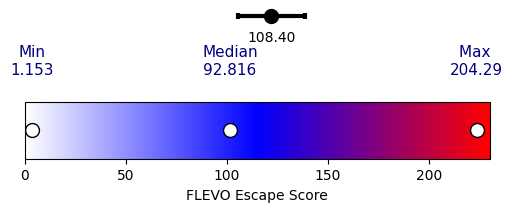

Plotting for sequence ID: seq32641


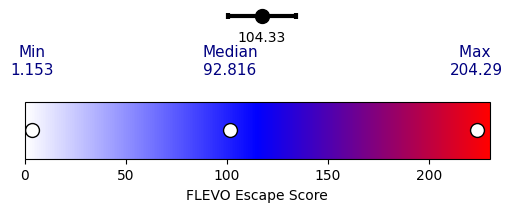

Plotting for sequence ID: seq32671


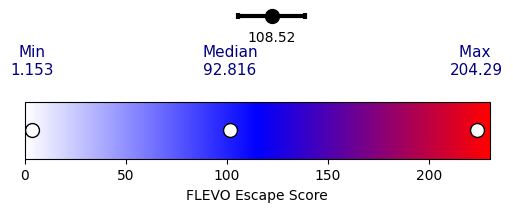

Plotting for sequence ID: seq32956


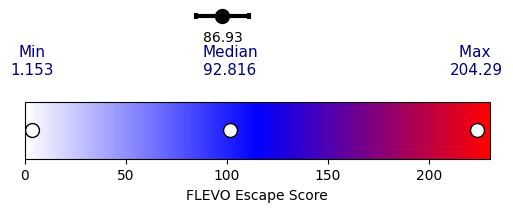

Plotting for sequence ID: seq32670


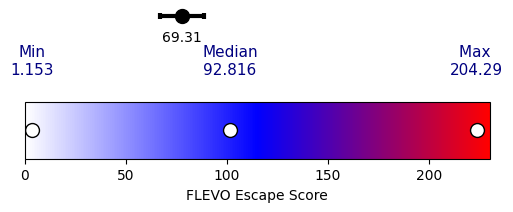

Plotting for sequence ID: seq32676


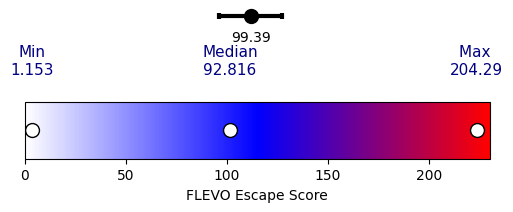

Plotting for sequence ID: seq32669


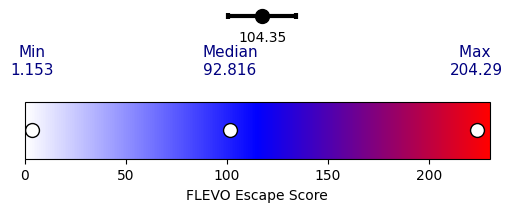

Plotting for sequence ID: seq33312


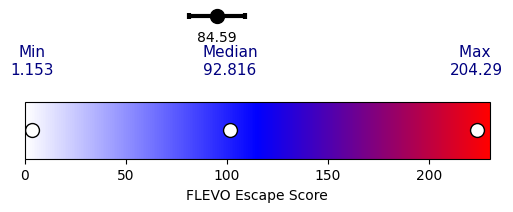

Plotting for sequence ID: seq32794


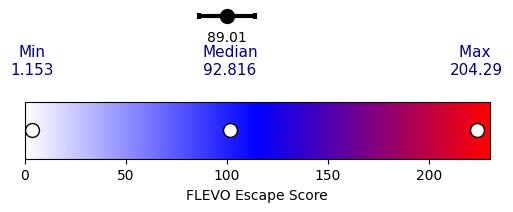

Plotting for sequence ID: seq32566


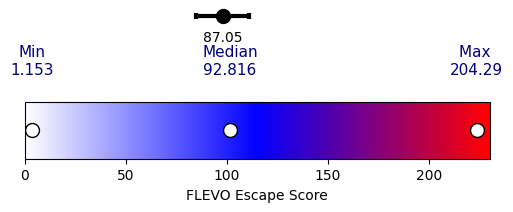

Plotting for sequence ID: seq8758


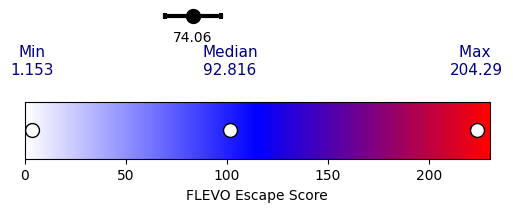

Batch processing complete. Results saved to 'processed_results.csv' and plots saved per sequence ID.


In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio.Seq import Seq
from Bio import SeqIO, AlignIO
import subprocess
from io import StringIO

# Fallback Levenshtein distance implementation
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

# Load escape scores
evescape_df = pd.read_csv("prrsv_scaled_flevo_scores.csv")
evescape_df["mutations"] = evescape_df["wt"] + evescape_df["i"].astype(str) + evescape_df["mut"]
evescape_dict_pos = dict(zip(evescape_df["mutations"], evescape_df["evescape"] - evescape_df["evescape"].min()))
evescape_dict_sigmoid = dict(zip(evescape_df["mutations"], evescape_df["evescape"].apply(lambda x: 1 / (1 + math.exp(-x)))))

ref_aa_seq = "MLEKCLTAGYCSQLLFFWCIVPFCFAALVNAASNSSSHLQLIYNLTICELNGTDWLNQKFDWAVETFVIFPVLTHIVSYGALTTSHFLDTAGLITVSTAGYYHGRYVLSSIYAVFALAALICFVIRLTKNCMSWRYSCTRYTNFLLDTKGNLYRWRSPVVIERRGKVEVGDHLIDLKRVVLDGSAATPITKISAEQWGRP"

def get_mutations(wt_seq, query_seq):
    with open("temp.fasta", "w") as f:
        f.write(">WT\n" + wt_seq + "\n")
        f.write(">QUERY\n" + query_seq + "\n")
    result = subprocess.run(
        ["mafft", "--globalpair", "--maxiterate", "1000", "--quiet", "temp.fasta"],
        capture_output=True, text=True, check=True
    )
    alignment = AlignIO.read(StringIO(result.stdout), "fasta")
    wt_aligned = str(alignment[0].seq)
    query_aligned = str(alignment[1].seq)
    mutations = []
    wt_pos = 0
    for wt_res, q_res in zip(wt_aligned, query_aligned):
        if wt_res != "-":
            wt_pos += 1
        if wt_res == "-" and q_res != "-":
            mutations.append(f"{wt_aligned[wt_pos-1]}{wt_pos}ins{q_res}")
        elif wt_res != "-" and q_res == "-":
            mutations.append(f"{wt_res}{wt_pos}del")
        elif wt_res != "-" and q_res != "-" and wt_res != q_res:
            mutations.append(f"{wt_res}{wt_pos}{q_res}")
    return mutations

def plot_colorbar_with_point_and_uncertainty(seqid, min_val, max_val, point_val, mean_val,
                                             label="FLEVO Escape Score", uncertainty=0.5):
    whisker_length = uncertainty / 100
    fig, ax = plt.subplots(figsize=(6, 1.5))
    fig.subplots_adjust(bottom=0.5)
    colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    norm = mpl.colors.Normalize(vmin=0, vmax=230)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.set_label(label)
    point_position = (point_val - 0) / (max_val - 0)
    ax.plot(point_position, 2.5, marker='o', markersize=10,
            markerfacecolor='black', markeredgecolor='black', transform=ax.transAxes, clip_on=False)
    ax.text(point_position, 2.0, f"{point_val:.2f}", color='black', ha='center', va='bottom', transform=ax.transAxes)
    ax.hlines(y=2.5,
              xmin=point_position - whisker_length / 2,
              xmax=point_position + whisker_length / 2,
              color='black', linewidth=3,
              transform=ax.transAxes, clip_on=False)
    ax.vlines(x=[point_position - whisker_length / 2, point_position + whisker_length / 2],
              ymin=2.45, ymax=2.55,
              color='black', linewidth=3,
              transform=ax.transAxes, clip_on=False)
    critical_points = [204.29, 92.816, 3.253]
    critical_labels = ['Max \n204.29', 'Median\n92.816', 'Min\n1.153']
    for rp, rl in zip(critical_points, critical_labels):
        xpos = rp / 210
        y_random = 0.5
        ax.plot(xpos, y_random, marker='o', markersize=10,
                markerfacecolor='white', markeredgecolor='black', linewidth=1.5, transform=ax.transAxes)
        ax.text(xpos, y_random + 1.5, rl, ha='center', va='top', fontsize=11, color='navy', transform=ax.transAxes)
    plt.show()

input_df = pd.read_csv("test.csv")
results = []

for index, row in input_df.iterrows():
    seq_id = row['id']
    raw_seq = row['sequence']
    query_seq_input = ''.join(raw_seq.split()).replace('-', '').upper()
    query_seq = Seq(query_seq_input)
    lev_dist = levenshtein_distance(ref_aa_seq, str(query_seq))
    similarity = (1 - lev_dist / 200) * 100
    mutations = get_mutations(ref_aa_seq, str(query_seq))
    filtered_mutations = [m for m in mutations if 'del' not in m and 'ins' not in m]
    score_pos = sum(evescape_dict_pos.get(m, 0) for m in filtered_mutations)
    score_sigmoid = sum(evescape_dict_sigmoid.get(m, 0) for m in filtered_mutations)
    uncertainty = 100 if similarity < 30 else (lev_dist / 200) * 100
    minimum = 1.1572728000000003
    maximum = 204.29259040000005
    mean = 92.8164662

    print(f"Plotting for sequence ID: {seq_id}")  # <-- Add this line
    plot_colorbar_with_point_and_uncertainty(seq_id, minimum, maximum, score_pos, mean, uncertainty=uncertainty)
    results.append({
        "seqid": seq_id,
        "Levenshtein Distance": lev_dist,
        "Similarity (%)": similarity,
        "EscaPRRS Score": score_pos,
        "Uncertainty (%)": uncertainty,
        "Mutations": ", ".join(filtered_mutations)
    })

results_df = pd.DataFrame(results)
results_df.to_csv("processed_results.csv", index=False)
print("Batch processing complete. Results saved to 'processed_results.csv' and plots saved per sequence ID.")